## HW02 Code

### Name: Sharrey Suhendra

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.  If you have trouble with the latter, a nice approach is to download in Markdown format, and then use a Markdown reader to print to PDF, which tends to produce nicer results than does printing from a browser.)

In [1]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    for i in polynomials:
        polyTransform = PolynomialFeatures(degree = i)
        xTransform = polyTransform.fit_transform(x)
        linearRegressionModel = linear_model.LinearRegression()
        linearRegressionModel.fit(xTransform, y)
        yPredict = linearRegressionModel.predict(xTransform)
        prediction_list.append(yPredict)
        mseTrain = mean_squared_error(y, yPredict)
        error_list.append(mseTrain)
        
    return prediction_list, error_list
    

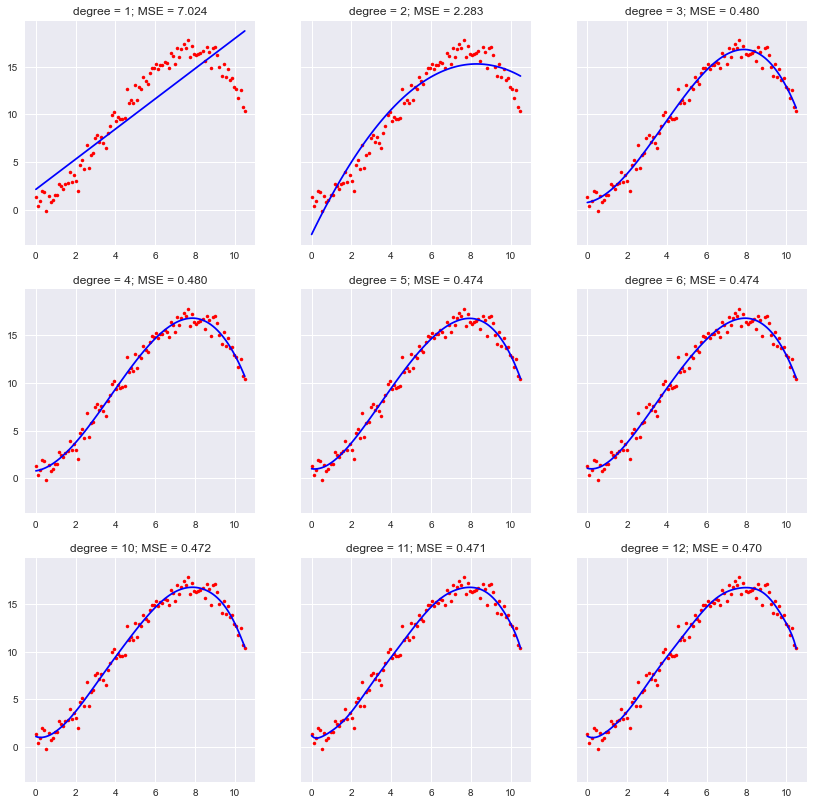

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
degrees = [1,2,3,4,5,6,10,11,12]
p_list, e_list = test_polynomials(degrees)
plot_predictions(degrees, p_list, e_list)

#### 1.2 Discuss the results seen in the plots above

Since all the data points were used as the training model, we note that as the order polynomial degree rises, the model will be more precise to the training data such that it will hit more data points. This can be proven with the results above.

Based upon MSE, the results show that as the polynomial degree increases, so does the effectiveness of the model; MSE decreases, indicating the regression line is getting closer to the data points. The decrease in MSE was drastic bewteen degree 1, 2 and 3 polynomials, and very subtle in the rest of the degrees up to degree 12. 

Furthermore, just by looking at the data point itself, it seems to follow at least a degree 3 polynomial which is why the model did poorly on degree 1 and 2; Their MSE is large indicating the regression line is not close to the data points.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.  (**Don't modify this.**)

In [7]:
# A simple function for generating different data-folds.
#
# DO NOT MODIFY THIS CODE.
def make_folds(x_data, y_data, num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       x_data: input data.
       y_data: matching output data.
           (Expected that these are of the same length.)
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x_data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y_data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
        
    return x_folds, y_folds

In [8]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

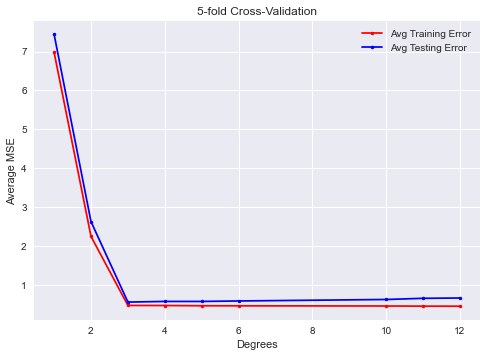

,Degrees,Average Training Error,Average Testing Error
,1,6.977641,7.441157
,2,2.245920,2.625608
,3,0.471621,0.558083
,4,0.469909,0.574623
,5,0.463663,0.574580
,6,0.462069,0.586606
,10,0.457199,0.624748
,11,0.453294,0.654949
,12,0.451891,0.662661


In [9]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

def FiveFoldCrossVal(polynomials, xTrain, yTrain, xTest, yTest):
    TrainTracker = list()
    TestTracker = list()
    ind = list()
    for i in polynomials:
        mseTrain = 0
        mseTest = 0
        for j in range(5):
            polyTransform = PolynomialFeatures(degree = i)
            xTrainTransform = polyTransform.fit_transform(xTrain[j])
            xTestTransform = polyTransform.fit_transform(xTest[j])
            linearRegressionModel = linear_model.LinearRegression()
            linearRegressionModel.fit(xTrainTransform, yTrain[j])
            yTrainPredict = linearRegressionModel.predict(xTrainTransform)
            yTestPredict = linearRegressionModel.predict(xTestTransform)      
            mseTrain += mean_squared_error(yTrain[j], yTrainPredict)
            mseTest += mean_squared_error(yTest[j], yTestPredict)  
        TrainTracker.append(mseTrain/5)
        TestTracker.append(mseTest/5)
        ind.append('')
    return TrainTracker, TestTracker, ind

x_folds, y_folds = make_folds(x, y, 5)
polynomials = [1,2,3,4,5,6,10,11,12]

xTrain_one = np.concatenate((x_folds[1], x_folds[2], x_folds[3], x_folds[4]))
yTrain_one = np.concatenate((y_folds[1], y_folds[2], y_folds[3], y_folds[4]))
xTrain_two = np.concatenate((x_folds[0], x_folds[2], x_folds[3], x_folds[4]))
yTrain_two = np.concatenate((y_folds[0], y_folds[2], y_folds[3], y_folds[4]))
xTrain_three = np.concatenate((x_folds[0], x_folds[1], x_folds[3], x_folds[4]))
yTrain_three = np.concatenate((y_folds[0], y_folds[1], y_folds[3], y_folds[4]))
xTrain_four = np.concatenate((x_folds[0], x_folds[1], x_folds[2], x_folds[4]))
yTrain_four = np.concatenate((y_folds[0], y_folds[1], y_folds[2], y_folds[4]))
xTrain_five = np.concatenate((x_folds[0], x_folds[1], x_folds[2], x_folds[3]))
yTrain_five = np.concatenate((y_folds[0], y_folds[1], y_folds[2], y_folds[3]))
xTr = list([xTrain_one, xTrain_two, xTrain_three, xTrain_four, xTrain_five])
yTr = list([yTrain_one, yTrain_two, yTrain_three, yTrain_four, yTrain_five])

TrainError, TestError, i = FiveFoldCrossVal(degrees, xTr, yTr, x_folds, y_folds)

plt.plot(polynomials, TrainError, '.r-', label = 'Avg Training Error')
plt.plot(polynomials, TestError, '.b-', label = 'Avg Testing Error')
plt.title('5-fold Cross-Validation')
plt.xlabel('Degrees')
plt.ylabel('Average MSE')
plt.legend()
plt.show()

data = {'Degrees':degrees, 'Average Training Error':TrainError, 'Average Testing Error': TestError}
table = pd.DataFrame(data, index = i)
table

#### 2.2 Discuss the results seen in the plots above

Based on the plotted results, the training MSE data line remains below the testing MSE data line for every degree polynomial; This makes sense because the regression model is created using training data and thus tends to be a better fit for training data than testing data.

Both the training and testing error lines show the same trends from degree 1 to 3, they both decreased. From degrees 3 to 12, the training error decreased slowly. However, the testing error increased slowly from degrees 3 to 12 (with a very small drop from degree 4 to 5).

Looking at the error trends, we can find where underfitting and overfitting occured. Underfitting occured in degrees 1 to 3 because for each models, there was both a poor performance on the training data and generalization to the testing data. Overfitting occured in degrees around degree 5 to 12 because for each model, there was good performance on the training data but the testing error to the testing data starts to increase.

### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 3.1 Cross-validation for each regularization strength value

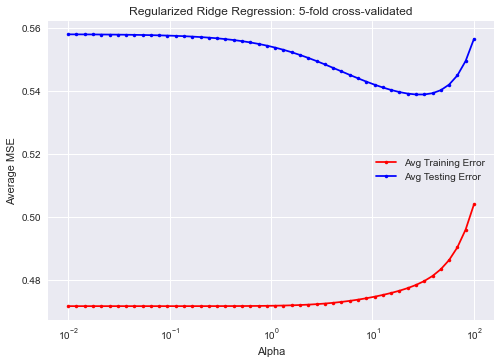

,Alpha,Average Training Error,Average Testing Error
,0.010000,0.471621,0.558036
,0.012068,0.471621,0.558026
,0.014563,0.471621,0.558015
,0.017575,0.471621,0.558001
,0.021210,0.471621,0.557984
,0.025595,0.471621,0.557963
,0.030888,0.471621,0.557939
,0.037276,0.471621,0.557909
,0.044984,0.471621,0.557873
,0.054287,0.471621,0.557831


In [10]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

def RegularizedRegression(polynomial, alpha, xTrain, yTrain, xTest, yTest):
    TrainTracker = list()
    TestTracker = list()
    ind = list()
    polyTransform = PolynomialFeatures(degree = 3)
    for a in alpha:
        ridgereg = linear_model.Ridge(alpha = a)
        mseTrain = 0
        mseTest = 0
        for i in range(5):
            xTrainTransform = polyTransform.fit_transform(xTrain[i])
            xTestTransform = polyTransform.fit_transform(xTest[i])
            ridgereg.fit(xTrainTransform, yTrain[i])
            y_trainPred = ridgereg.predict(xTrainTransform)
            y_testPred = ridgereg.predict(xTestTransform)
            mseTrain += mean_squared_error(yTrain[i], y_trainPred)
            mseTest += mean_squared_error(yTest[i], y_testPred)
        TrainTracker.append(mseTrain/5)
        TestTracker.append(mseTest/5)
        ind.append('')
    return TrainTracker, TestTracker, ind

a = np.logspace(-2, 2, base = 10, num = 50)
TrainError, TestError, i = RegularizedRegression(3, a, xTr, yTr, x_folds, y_folds)

plt.xscale('log')
plt.plot(a, TrainError, '.r-', label = 'Avg Training Error')
plt.plot(a, TestError, '.b-', label = 'Avg Testing Error')
plt.title('Regularized Ridge Regression: 5-fold cross-validated')
plt.xlabel('Alpha')
plt.ylabel('Average MSE')
plt.legend()
plt.show()

data = {'Alpha':a, 'Average Training Error':TrainError, 'Average Testing Error': TestError}
table = pd.DataFrame(data, index = i)
table

#### 3.2 Discuss the results seen in the plots above

The main reason to take a regularization approach is to avoid overfitting; We want to avoid over-fitting so that the models we learn will do better on the testing data that was not part of the known training set. So, by at the trend of the average testing error, we can see how the how useful the increase in regularization strength is in avoiding overfitting.

A regularization strength of a fraction that is less than 1 is less useful as it doesn't do much change in avoiding overfitting (It does help a bit based on the small fraction decrease of testing error). Regularization strength of greater than 1 seemed to create a bigger change in the testing error results. An alpha from 10 to 30 reduces the average testing error from about 0.553 to 0.538, however beyond that up to alpha 100, it increased back up to 0.556. 

We also note that the training error data increases the whole time the regularization strength increases. However, just like the testing error, the training error increases by very little when the strength is less than 1. Beyond 1, the training error increases gradually up to alpha around 30 and beyond that it increases drastically.

So, when regularization strength is greater than 1 but not too high, then it is helpful in avoiding overfitting. 